In [ ]:
import math
import matplotlib.pyplot as plt #plotting
import numpy as np
import gzip
import re
import cv2
from skimage import transform
import pandas as pd

In [ ]:
pip install boxsdk

In [ ]:
import boxsdk
from boxsdk import Client, OAuth2

# Define client ID, client secret, and developer token.
ACCESS_TOKEN = "ACCESS_TOKEN"
CLIENT_ID = "CLIENT_ID"
CLIENT_SECRET = "CLIENT_SECRET"

# Create OAuth2 object. It's already authenticated, thanks to the developer token.
oauth2 = OAuth2(CLIENT_ID, CLIENT_SECRET, access_token=ACCESS_TOKEN)

client = Client(oauth2)

# Create the authenticated client
# client = Client(oauth2, LoggingNetwork())

In [ ]:
def navigTo(folder, file_name):
    items = folder.get_items()
    for item in items:
        if (item.name == file_name):
            return item
    return -1

def navig(client, file_names):
    folder_init = client.root_folder()
    for i in range(len(file_names)):
        folder_init = navigTo(folder_init, file_names[i])
    return folder_init

def printHeader(nrrdFile):
    content = nrrdFile.content()
    index = content.find(b'\n\n')
    print(content[:index].decode())

def getData(nrrdFile):
    content = nrrdFile.content()
    index = content.find(b'\n\n')
    return content[index+2:]

In [ ]:
def loadNRRD(nrrdFile):
    if (re.match(r".*\.nrrd$", nrrdFile.name)):
        content = nrrdFile.content()
        index = content.find(b'\n\n')
        content_bytes = content[index+2:]
        content_header = content[:index]
    else:
        return -1

    if ((content_bytes[:2]) == b'\x1f\x8b'):
        content_bytes = gzip.decompress(content_bytes)

    #Find the type stored
    type_index_start = content_header.find(b"type: ") + 6
    type_index_end = content_header.find(b"\n", type_index_start)
    content_type = content_header[type_index_start:type_index_end]

    #Find the dimensions stored
    dims_index_start = content_header.find(b"sizes: ") + 7
    dims_index_end = content_header.find(b"\n", dims_index_start)
    dims_type = content_header[dims_index_start:dims_index_end]
    firstSpace_index = dims_type.find(b" ")
    secondSpace_index = dims_type.find(b" ", firstSpace_index+1)
    dim3 = int(dims_type[:firstSpace_index])
    dim2 = int(dims_type[firstSpace_index:secondSpace_index])
    dim1 = int(dims_type[secondSpace_index:])

    raw_data = None
    if (content_type == b"unsigned char"):
        raw_data = np.frombuffer(content_bytes, dtype=np.ubyte)
    if (content_type == b"short"):
        raw_data = np.frombuffer(content_bytes, dtype=np.short)
    if (content_type == b"unsigned short"):
        raw_data = np.frombuffer(content_bytes, dtype=np.ushort)

    raw_data = raw_data.reshape([dim1, dim2, dim3])

    return raw_data

In [ ]:
#The distance between axial slices is 3.3 mm.

def print_NRRD_dim_sizes(nrrdFile):
    if (re.match(r".*\.nrrd$", nrrdFile.name)):
        content = nrrdFile.content()
        # print(content[:400])
        index = content.find(b'space directions:')+len('space directions:')
        index2 = content.find(b'\n', index)
        content_header = content[index:index2]
        # print(content_header)

        input_string = content_header.decode('utf-8')  # Decode from bytes to string

        # Extract numbers using regex
        numbers = re.findall(r"-?\d+\.\d+|-?\d+", input_string)

        # Convert strings to floats
        numbers = [float(num) for num in numbers]

        print(numbers)

        ax1 = np.array(numbers[0:3])
        ax2 = np.array(numbers[3:6])
        ax3 = np.array(numbers[6:9])

        ax1_size = np.sqrt(np.sum(ax1*ax1))
        ax2_size = np.sqrt(np.sum(ax2*ax2))
        ax3_size = np.sqrt(np.sum(ax3*ax3))

        print(ax1_size, ax2_size, ax3_size)
    else:
        content = nrrdFile.content()
        print("Raw File")
        return -1

In [ ]:
def loadRaw(rawFile, size = 512):
    if (re.match(r".*\.raw$", rawFile.name)):
        content_bytes = rawFile.content()
    else:
        return -1

    if ((content_bytes[:2]) == b'\x1f\x8b'):
        content_bytes = gzip.decompress(content_bytes)

    raw_data = np.frombuffer(content_bytes, dtype=np.short)

    frames = int(len(raw_data)/(size*size))

    raw_data = raw_data.reshape([frames, size, size])

    return raw_data

In [ ]:
def plotScans(raw_data):
    num_frames = raw_data.shape[0]
    if (num_frames > 2):
        num_rows = math.ceil(math.sqrt(num_frames))
        num_cols = math.ceil(num_frames/num_rows)
        fig, arr = plt.subplots(num_cols, num_rows, figsize=(10, int(10/num_rows*num_cols)))
        for i in range(num_frames):
            arr[i%num_cols][int(i/num_cols)].imshow(raw_data[i])
    else:
        fig, arr = plt.subplots(1, 2, figsize=(10, 5))
        arr[0].imshow(raw_data[0])
        arr[1].imshow(raw_data[1])

In [ ]:
def plotScan(raw_data):
    fig, arr = plt.subplots(1, 1, figsize=(4, 4))
    arr.imshow(raw_data)

In [ ]:
parent_source_folder = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'corrections', 'new_AX_T1_corrections_after_02_17_25'])
parent_dest_folder = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training'])


for patient_folder in parent_source_folder.get_items():
    patient_ID = patient_folder.name[len("Annotations_"):]
    print(patient_ID)
    source_folder = patient_folder
    for dest_patient_folder in parent_dest_folder.get_items():
        if (dest_patient_folder.name == patient_ID):
            annotations_folder = navigTo(dest_patient_folder, "Annotations")
            if (navigTo(annotations_folder, "Old_AX_T1_02_17_25") == -1):
                old_AX_T1_folder = navigTo(annotations_folder, "AX_T1")
                if (old_AX_T1_folder != -1):
                    old_AX_T1_folder.rename("Old_AX_T1_02_17_25")

                dest_folder = annotations_folder.create_subfolder("AX_T1")

                # Move each file to the destination folder
                for item in source_folder.get_items():
                    if item.type == 'file':  # Ensure it's a file, not a subfolder
                        print(f"Copying {item.name} (ID: {item.id})")
                        item.copy(parent_folder = dest_folder)

10547064
10598503
Copying 16 Ax T1 ORBITS.nrrd (ID: 1780320769504)
Copying 2025-01-22-Scene.mrml (ID: 1780322144872)
Copying 2025-01-22-Scene.png (ID: 1780327431834)
Copying LG_Segmentations-label.nrrd (ID: 1780320601663)
Copying LG_Segmentations-label_ColorTable.ctbl (ID: 1780320822849)
Copying LG_Segmentations.seg.nrrd (ID: 1780327405789)
12698880
Copying 14 AX T1 (ORBITS).nrrd (ID: 1780317076792)
Copying 2024-04-01-Scene.mrml (ID: 1780317822137)
Copying 2024-04-01-Scene.png (ID: 1780321259066)
Copying LG_Segmentations-label.nrrd (ID: 1780320695291)
Copying LG_Segmentations-label_ColorTable.txt (ID: 1780320791649)
Copying LG_Segmentations.seg.nrrd (ID: 1780318043900)
Copying LG_Segmentations_LLG.stl (ID: 1780321926709)
Copying LG_Segmentations_RLG.stl (ID: 1780321633365)
13121977
Copying 17 Ax T1 ORBITS.nrrd (ID: 1780316852824)
Copying 2025-01-23-Scene.mrml (ID: 1780318893524)
Copying 2025-01-23-Scene.png (ID: 1780317050338)
Copying LG_Segmentations-label.nrrd (ID: 1780321427597)
Cop

In [ ]:
parent_dir = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training'])
pattern = r'\d{8}'#choosing all files with 8 number digits

In [ ]:
excel_dir = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'Tutorial', 'Scan Tracking.xlsx'])
output_path = "file.xlsx"
with open(output_path, 'wb') as output_file:
    excel_dir.download_to(output_file)

df = pd.read_excel(output_path)

POST_AX_T1_FS_segmenter = {}
AX_T1_segmenter = {}

for i in range(len(df)):
    POST_AX_T1_FS_segmenter[str(df.iloc[i]["Scan ID"])] = df.iloc[i]["POST AX T1 FS"]
    AX_T1_segmenter[str(df.iloc[i]["Scan ID"])] = df.iloc[i]["AX T1"]

del df

In [ ]:
# Getting all AX T1 scan folders

AX_T1_scan_folders = []
AX_T1_scan_folders_names = []
AX_T1_scan_folders_missing = []

for item in parent_dir.get_items():
    if re.match(pattern, item.name):
        folder = navigTo(item, "Annotations")
        if (folder != -1):
            AX_T1_folder = navigTo(folder, "AX_T1")

            if (AX_T1_folder != -1):
                AX_T1_scan_folders.append(AX_T1_folder)
                AX_T1_scan_folders_names.append(item.name)
            else:
                AX_T1_scan_folders_missing.append(item.name)
        else:
            AX_T1_scan_folders_missing.append(item.name)

AX_T1_segmentations = []
AX_T1_scans = []
AX_T1_segmenters = []

for index, folder in enumerate(AX_T1_scan_folders):
    id_number = AX_T1_scan_folders_names[index]
    AX_T1_segmenters.append(AX_T1_segmenter[id_number])

    seg_num = len(AX_T1_segmentations)
    scans_num = len(AX_T1_scans)
    for item in folder.get_items():
        if re.match(r".*seg.nrrd$", item.name):
            AX_T1_segmentations.append(item)
            # print(item.name)
        if re.match(r'.*ORBIT.*\.nrrd$', item.name) or re.match(r".*Volume.raw$", item.name):
            AX_T1_scans.append(item)
            # print(item.name)
    print(AX_T1_scan_folders_names[index], " has ", len(AX_T1_segmentations) - seg_num, " segmentations")
    print(AX_T1_scan_folders_names[index], " has ", len(AX_T1_scans) - scans_num, " scans")

AX_T1_frame_sizes_axis2 = get_frame_sizes(AX_T1_segmentations)
AX_T1_segmentation_list = extract_scans(AX_T1_segmentations, AX_T1_frame_sizes_axis2)
AX_T1_segmentation_list = assign_correct_direction(AX_T1_segmentation_list)
AX_T1_segmentation_list_foreground = get_foreground_areas(AX_T1_segmentation_list)
AX_T1_IDs = get_IDs(AX_T1_segmentation_list, AX_T1_scan_folders_names)
AX_T1_scan_list = extract_scans(AX_T1_scans, AX_T1_frame_sizes_axis2)

AX_T1_segmentation_list_stacked = np.concatenate(AX_T1_segmentation_list, axis=0)
AX_T1_segmentation_list_stacked = AX_T1_segmentation_list_stacked.astype(np.int8)
AX_T1_scan_list_stacked = np.concatenate(AX_T1_scan_list, axis=0)

10547064  has  1  segmentations
10547064  has  1  scans
10598503  has  1  segmentations
10598503  has  1  scans
12698880  has  1  segmentations
12698880  has  1  scans
13121977  has  1  segmentations
13121977  has  1  scans
15681637  has  1  segmentations
15681637  has  1  scans
17597334  has  1  segmentations
17597334  has  1  scans
17598796  has  1  segmentations
17598796  has  1  scans
18833296  has  1  segmentations
18833296  has  1  scans
19172176  has  1  segmentations
19172176  has  1  scans
19726481  has  1  segmentations
19726481  has  1  scans
19828645  has  1  segmentations
19828645  has  1  scans
22053801  has  1  segmentations
22053801  has  1  scans
22460223  has  1  segmentations
22460223  has  1  scans
22543656  has  1  segmentations
22543656  has  1  scans
22747606  has  1  segmentations
22747606  has  1  scans
23688579  has  1  segmentations
23688579  has  1  scans
24123999  has  1  segmentations
24123999  has  1  scans
26199671  has  1  segmentations
26199671  has  1

In [ ]:
for i in range(len(AX_T1_scans)):
    print(AX_T1_IDs_old_unique[i], AX_T1_segmentations[i], AX_T1_segmentations_old[i])

10547064 <Box File - 1757156946425 (LG_Segmentations-label.nrrd)> <Box File - 1488263442643 (LG_Segmentations-label.nrrd)>
10598503 <Box File - 1757179672544 (LG_Segmentations-label.nrrd)> <Box File - 1488395630225 (LG_Segmentations-label.nrrd)>
12698880 <Box File - 1488456001838 (LG_Segmentations-label.nrrd)> <Box File - 1488456001838 (LG_Segmentations-label.nrrd)>
13121977 <Box File - 1757186531117 (LG_Segmentations-label.nrrd)> <Box File - 1488602128794 (LG_Segmentations-label.nrrd)>
15681637 <Box File - 1757212967414 (LG_Segmentations-label.nrrd)> <Box File - 1488760938594 (LG_Segmentations-label.nrrd)>
17597334 <Box File - 1490912007689 (LG_Segmentations-label_3.nrrd)> <Box File - 1490912007689 (LG_Segmentations-label_3.nrrd)>
17598796 <Box File - 1479048899952 (LG_Segmentations-label.nrrd)> <Box File - 1479048899952 (LG_Segmentations-label.nrrd)>
18833296 <Box File - 1757227422428 (LG_Segmentations-label.nrrd)> <Box File - 1488346850324 (LG_Segmentations-label_1.nrrd)>
19172176 <

In [ ]:
# Getting all AX T1 scan folders

AX_T1_scan_folders_old = []
AX_T1_scan_folders_names_old = []
AX_T1_scan_folders_missing_old = []

for item in parent_dir.get_items():
    if re.match(pattern, item.name):
        folder = navigTo(item, "Annotations")
        if (folder != -1):
            AX_T1_folder_old = navigTo(folder, "Old_AX_T1")
            if (AX_T1_folder_old == -1):
                AX_T1_folder_old = navigTo(folder, "AX_T1")
            else:
                print(item.name, "using old file")

            if (AX_T1_folder_old != -1):
                AX_T1_scan_folders_old.append(AX_T1_folder_old)
                AX_T1_scan_folders_names_old.append(item.name)
            else:
                AX_T1_scan_folders_missing_old.append(item.name)
        else:
            AX_T1_scan_folders_missing_old.append(item.name)

print(AX_T1_scan_folders_old)

# Getting the AX T1 segmentation file names, which are found within the AX T1 folders

AX_T1_segmentations_old = []
AX_T1_scans_old = []
AX_T1_segmenters_old = []

for index, folder in enumerate(AX_T1_scan_folders_old):
    id_number = AX_T1_scan_folders_names_old[index]
    AX_T1_segmenters_old.append(AX_T1_segmenter[id_number])

    seg_num = len(AX_T1_segmentations_old)
    scans_num = len(AX_T1_scans_old)
    for item in folder.get_items():
        if re.match(r".*seg.nrrd$", item.name):
            AX_T1_segmentations_old.append(item)
            # print(item.name)
        if re.match(r'.*ORBIT.*\.nrrd$', item.name) or re.match(r".*Volume.raw$", item.name):
            AX_T1_scans_old.append(item)
            # print(item.name)
    print(AX_T1_scan_folders_names_old[index], " has ", len(AX_T1_segmentations_old) - seg_num, " segmentations")
    print(AX_T1_scan_folders_names_old[index], " has ", len(AX_T1_scans_old) - scans_num, " scans")

AX_T1_frame_sizes_axis2_old = get_frame_sizes(AX_T1_segmentations_old)
AX_T1_segmentation_list_old = extract_scans(AX_T1_segmentations_old, AX_T1_frame_sizes_axis2_old)
AX_T1_segmentation_list_old = assign_correct_direction(AX_T1_segmentation_list_old)
AX_T1_segmentation_list_foreground_old = get_foreground_areas(AX_T1_segmentation_list_old)
AX_T1_IDs_old = get_IDs(AX_T1_segmentation_list, AX_T1_scan_folders_names_old)
AX_T1_scan_list_old = extract_scans(AX_T1_scans_old, AX_T1_frame_sizes_axis2_old)

AX_T1_segmentation_list_stacked_old = np.concatenate(AX_T1_segmentation_list_old, axis=0)
AX_T1_segmentation_list_stacked_old = AX_T1_segmentation_list_stacked_old.astype(np.int8)
AX_T1_scan_list_stacked_old = np.concatenate(AX_T1_scan_list_old, axis=0)

10547064 using old file
10598503 using old file
13121977 using old file
15681637 using old file
18833296 using old file
19172176 using old file
19828645 using old file
22053801 using old file
22543656 using old file
22747606 using old file
27680188 using old file
33747635 using old file
34115887 using old file
38331480 using old file
41084905 using old file
42676469 using old file
43126480 using old file
50161879 using old file
50886634 using old file
53842859 using old file
53892786 using old file
54531943 using old file
54654638 using old file
56234036 using old file
56580268 using old file
56938340 using old file
59102929 using old file
62670351 using old file
63323859 using old file
70098571 using old file
70663216 using old file
71428810 using old file
76789009 using old file
77131046 using old file
78379362 using old file
78497986 using old file
78838690 using old file
90226411 using old file
90878290 using old file
91833509 using old file
92438637 using old file
92936731 using o

In [ ]:
def extract_scans(scans, scan_sizes, AX_T1 = True):
    print("Extracting scans...")
    all_scan_data = []
    index = 0
    scan_len = len(scans)
    for scan in scans:

        print(scan)

        scan_data = None
        if (re.match(r'.*\.nrrd$', scan.name)):
            scan_data = loadNRRD(scan)
        elif (re.match(r'.*\.raw$', scan.name)):
            scan_data = loadRaw(scan, scan_sizes[index])

        print(np.sum(scan_data))

        scan_data = scan_data.transpose([1, 2, 0])
        scan_data = cv2.resize(scan_data, dsize=(512, 512), interpolation=cv2.INTER_LINEAR)
        scan_data = scan_data.transpose([2, 0, 1])

        all_scan_data.append(scan_data)

        if ((index+1) % 10 != 0):
            print(f"{index}/{scan_len}", end = "\t")
        else:
            print(f"{index}/{scan_len}")
        index = index + 1

    return all_scan_data

AX_T1_segmentation_list = extract_scans(AX_T1_segmentations, AX_T1_frame_sizes_axis2)

Extracting scans...
<Box File - 1757156946425 (LG_Segmentations-label.nrrd)>
6595
0/79	<Box File - 1757179672544 (LG_Segmentations-label.nrrd)>
6595
1/79	<Box File - 1488456001838 (LG_Segmentations-label.nrrd)>
2362
2/79	<Box File - 1757186531117 (LG_Segmentations-label.nrrd)>
3372
3/79	<Box File - 1757212967414 (LG_Segmentations-label.nrrd)>
2339
4/79	<Box File - 1490912007689 (LG_Segmentations-label_3.nrrd)>
6215
5/79	<Box File - 1479048899952 (LG_Segmentations-label.nrrd)>
4642
6/79	<Box File - 1757227422428 (LG_Segmentations-label.nrrd)>
5356
7/79	<Box File - 1759106912589 (LG_Segmentations-label.nrrd)>
6977
8/79	<Box File - 1490956299879 (LG_Segmentations-label_1.nrrd)>
5051
9/79
<Box File - 1759112768984 (LG_Segmentations-label.nrrd)>
5050
10/79	<Box File - 1759120206061 (LG_Segmentations-label.nrrd)>
295
11/79	<Box File - 1487398590003 (LG_Segmentations-label.nrrd)>
14906
12/79	<Box File - 1759135161100 (LG_Segmentations-label.nrrd)>
939
13/79	<Box File - 1759432767812 (LG_Segme

In [ ]:
# seg_file_new = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', '90878290', 'Annotations', 'AX_T1', 'LG_Segmentations.seg.nrrd'])
# seg_file_old = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', '90878290', 'Annotations', 'Old_AX_T1', 'LG_Segmentations.seg.nrrd'])

print(seg_file_new, seg_file_old)
seg_new = loadNRRD(seg_file_new)
seg_old = loadNRRD(seg_file_old)

print(np.sum(seg_new), np.sum(seg_old))

<Box File - 1779216335866 (LG_Segmentations.seg.nrrd)> <Box File - 1488238143991 (LG_Segmentations.seg.nrrd)>
8038 4088


In [ ]:
AX_T1_IDs_unique = np.unique(AX_T1_IDs)
AX_T1_IDs_old_unique = np.unique(AX_T1_IDs_old)
for i in range(len(AX_T1_segmentation_list)):
    print(AX_T1_IDs_unique[i], np.sum(AX_T1_segmentation_list[i]), np.sum(AX_T1_segmentation_list_old[i]), np.sum(AX_T1_segmentation_list[i]) - np.sum(AX_T1_segmentation_list_old[i]))


10547064 6595 4593 2002
10598503 6595 9222 18446744073709548989
12698880 9782 9782 0
13121977 3372 8942 18446744073709546046
15681637 2339 8278 18446744073709545677
17597334 6215 6215 0
17598796 4642 4642 0
18833296 5357 4319 1038
19172176 5602 8225 18446744073709548993
19726481 5051 5051 0
19828645 4123 4950 18446744073709550789
22053801 295 8842 18446744073709543069
22460223 14906 14906 0
22543656 3898 5128 18446744073709550386


<ipython-input-84-2e9e405fbdee>:4: RuntimeWarning: overflow encountered in scalar subtract
  print(AX_T1_IDs_unique[i], np.sum(AX_T1_segmentation_list[i]), np.sum(AX_T1_segmentation_list_old[i]), np.sum(AX_T1_segmentation_list[i]) - np.sum(AX_T1_segmentation_list_old[i]))


22747606 4382 2653 1729
23688579 4191 4191 0
24123999 7588 7588 0
26199671 7588 7588 0
27680188 3068 5072 18446744073709549612
29268564 7278 7278 0
30108100 6311 6311 0
33747635 7060 4478 2582
33991303 4353 4353 0
34115887 6387 5972 415
36492695 5553 5553 0
37434264 3932 3932 0
38041148 2173 2173 0
38331480 7134 8341 18446744073709550409
39680487 4544 4544 0
41084905 5949 4408 1541
42130844 3282 3282 0
42676469 3153 2721 432
43126480 7142 4947 2195
43743150 8759 8759 0
44109166 6242 6242 0
49616004 6444 6444 0
50161879 8749 13121 18446744073709547244
50886634 2450 2956 18446744073709551110
52009570 2542 2542 0
53842859 6191 4812 1379
53892786 4981 4062 919
54531943 7727 3704 4023
54654638 6508 3348 3160
56234036 11085 9871 1214
56580268 7015 3188 3827
56938340 13954 10951 3003
59102929 7930 5252 2678
60217599 5593 5593 0
62670351 11263 5957 5306
63323859 5307 2708 2599
64574809 9352 9352 0
65843911 15542 15542 0
67686049 3046 3046 0
69305171 5756 5756 0
70098571 10753 4615 6138
7015887

In [ ]:
indices = [1, 7, 73]
AX_T1_segmentation_list_copy = []
AX_T1_scan_list_copy = []
AX_T1_segmentation_list_old_copy = []
AX_T1_scan_list_old_copy = []
for i in range(79):
    if i not in indices:
        AX_T1_segmentation_list_copy.append(AX_T1_segmentation_list[i])
        AX_T1_scan_list_copy.append(AX_T1_scan_list[i])
        AX_T1_segmentation_list_old_copy.append(AX_T1_segmentation_list_old[i])
        AX_T1_scan_list_old_copy.append(AX_T1_scan_list_old[i])

AX_T1_segmentation_list_copy_stacked = np.concatenate(AX_T1_segmentation_list_copy, axis=0)
AX_T1_segmentation_list_copy_stacked = AX_T1_segmentation_list_copy_stacked.astype(np.int8)
AX_T1_scan_list_copy_stacked = np.concatenate(AX_T1_scan_list_copy, axis=0)

AX_T1_segmentation_list_copy_stacked_old = np.concatenate(AX_T1_segmentation_list_old_copy, axis=0)
AX_T1_segmentation_list_copy_stacked_old = AX_T1_segmentation_list_copy_stacked_old.astype(np.int8)
AX_T1_scan_list_copy_stacked_old = np.concatenate(AX_T1_scan_list_old_copy, axis=0)

In [ ]:
for i in range(len(AX_T1_segmentation_list_copy)):
    print(i, np.sum(AX_T1_segmentation_list_copy[i]) - np.sum(AX_T1_segmentation_list_old_copy[i]))

0 2002
1 0
2 -5570
3 -5939
4 0
5 0
6 -2629
7 0
8 -834
9 -8547
10 0
11 -1210
12 1729
13 0
14 0
15 0
16 -1964
17 0
18 0
19 2602
20 0
21 415
22 0
23 0
24 0
25 -1207
26 0
27 1543
28 0
29 432
30 2200
31 0
32 0
33 0
34 -4372
35 -506
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0


In [ ]:
for i in range(len(AX_T1_scan_list_copy)):
    print(i, np.sum(AX_T1_scan_list_copy[i]) - np.sum(AX_T1_scan_list_old_copy[i]))

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0.0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0


In [ ]:
AX_T1_segmentation_list_stacked_old = AX_T1_segmentation_list_stacked_old[:-1]

In [ ]:
for i in range(len(AX_T1_segmentation_list)):
    if (AX_T1_segmentation_list[i].shape != AX_T1_segmentation_list_old[i].shape) or (AX_T1_scan_list[i].shape != AX_T1_scan_list_old[i].shape):
        print(i, AX_T1_segmentation_list[i].shape, AX_T1_segmentation_list_old[i].shape, AX_T1_scan_list[i].shape, AX_T1_scan_list_old[i].shape)

1 (16, 512, 512) (20, 512, 512) (16, 512, 512) (20, 512, 512)
7 (21, 512, 512) (18, 512, 512) (21, 512, 512) (18, 512, 512)
73 (23, 512, 512) (23, 512, 512) (16, 512, 512) (23, 512, 512)


In [ ]:
for i in range(len(AX_T1_scan_list)):
    if (AX_T1_scan_list[i].shape != AX_T1_scan_list_old[i].shape):
        print(i, AX_T1_scan_list[i].shape, AX_T1_scan_list_old[i].shape)

1 (16, 512, 512) (20, 512, 512)
7 (21, 512, 512) (18, 512, 512)
73 (16, 512, 512) (23, 512, 512)


In [ ]:
for i in range(len(AX_T1_segmentation_list)):
    if (AX_T1_segmentation_list[i].shape != AX_T1_segmentation_list_old[i].shape):
        print(i, AX_T1_segmentation_list[i].shape, AX_T1_segmentation_list_old[i].shape)

In [ ]:
diff = np.sum(AX_T1_segmentation_list_copy_stacked - AX_T1_segmentation_list_copy_stacked_old, axis = (1, 2))
diff_norm = np.sum((AX_T1_segmentation_list_copy_stacked - AX_T1_segmentation_list_copy_stacked_old), axis = (1, 2)) / (np.sum(AX_T1_segmentation_list_copy_stacked_old, axis = (1, 2))+1)
for i, d in enumerate(diff):
    if (d != 0):
        print(i, d, diff_norm[i])

6 101 0.21767241379310345
7 199 0.48418491484184917
8 507 1.3814713896457766
9 -189 -0.15144230769230768
10 526 0.40275650842266464
11 300 0.37359900373599003
12 558 558.0
40 -542 -0.998158379373849
41 -658 -0.9984825493171472
42 -259 -0.16423589093214966
43 -721 -0.39528508771929827
44 -1278 -0.7115812917594655
45 -1536 -0.7785098834262545
46 -576 -0.9982668977469671
56 -569 -0.9982456140350877
57 -1146 -0.999128160418483
58 -1183 -0.9991554054054054
59 -600 -0.5676442762535477
60 -784 -0.5025641025641026
61 -838 -0.43040575243965074
62 -819 -0.998780487804878
115 -1259 -0.7041387024608501
116 -170 -0.11447811447811448
117 -311 -0.12239275875639512
118 18 0.011378002528445006
119 -907 -0.998898678414097
173 -151 -0.3400900900900901
174 -656 -0.4809384164222874
175 -171 -0.10052910052910052
176 -7 -0.004685408299866131
177 151 151.0
190 -263 -0.9962121212121212
191 -490 -0.9979633401221996
192 -756 -0.9986789960369881
193 -736 -0.9986431478968792
194 -633 -0.6813778256189451
195 -1327 

In [ ]:
i = 63
plt.imshow(AX_T1_segmentation_list_stacked[i])
plt.figure()
plt.imshow(AX_T1_segmentation_list_stacked_old[i])
plt.figure()
plt.imshow(AX_T1_scan_list_stacked[i])

In [ ]:
# Getting all POST AX T1 scan folders

POST_AX_T1_FS_scan_folders = []
POST_AX_T1_FS_scan_folders_names = []
POST_AX_T1_FS_scan_folders_missing = []

for item in parent_dir.get_items():
    if re.match(pattern, item.name):
        folder = navigTo(item, "Annotations")
        if (folder != -1):
            POST_AX_T1_FS_folder = navigTo(folder, "POST_AX_T1_FS")

            if (POST_AX_T1_FS_folder != -1):
                POST_AX_T1_FS_scan_folders.append(POST_AX_T1_FS_folder)
                POST_AX_T1_FS_scan_folders_names.append(item.name)
            else:
                POST_AX_T1_FS_scan_folders_missing.append(item.name)
        else:
            POST_AX_T1_FS_scan_folders_missing.append(item.name)

In [ ]:
excel_dir = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'Tutorial', 'Scan Tracking.xlsx'])
output_path = "file.xlsx"
with open(output_path, 'wb') as output_file:
    excel_dir.download_to(output_file)

df = pd.read_excel(output_path)

POST_AX_T1_FS_segmenter = {}
AX_T1_segmenter = {}

for i in range(len(df)):
    POST_AX_T1_FS_segmenter[str(df.iloc[i]["Scan ID"])] = df.iloc[i]["POST AX T1 FS"]
    AX_T1_segmenter[str(df.iloc[i]["Scan ID"])] = df.iloc[i]["AX T1"]

del df

In [ ]:
# Getting the AX T1 segmentation file names, which are found within the AX T1 folders

AX_T1_segmentations = []
AX_T1_scans = []
AX_T1_segmenters = []

for index, folder in enumerate(AX_T1_scan_folders):
    id_number = AX_T1_scan_folders_names[index]
    AX_T1_segmenters.append(AX_T1_segmenter[id_number])

    seg_num = len(AX_T1_segmentations)
    scans_num = len(AX_T1_scans)
    for item in folder.get_items():
        if re.match(r".*label.*\.nrrd$", item.name):
            AX_T1_segmentations.append(item)
            # print(item.name)
        if re.match(r'.*ORBIT.*\.nrrd$', item.name) or re.match(r".*Volume.raw$", item.name):
            AX_T1_scans.append(item)
            # print(item.name)
    print(AX_T1_scan_folders_names[index], " has ", len(AX_T1_segmentations) - seg_num, " segmentations")
    print(AX_T1_scan_folders_names[index], " has ", len(AX_T1_scans) - scans_num, " scans")


10547064  has  1  segmentations
10547064  has  1  scans
10598503  has  1  segmentations
10598503  has  1  scans
12698880  has  1  segmentations
12698880  has  1  scans
13121977  has  1  segmentations
13121977  has  1  scans
15681637  has  1  segmentations
15681637  has  1  scans
17597334  has  1  segmentations
17597334  has  1  scans
17598796  has  1  segmentations
17598796  has  1  scans
18833296  has  1  segmentations
18833296  has  1  scans
19172176  has  1  segmentations
19172176  has  1  scans
19726481  has  1  segmentations
19726481  has  1  scans
19828645  has  1  segmentations
19828645  has  1  scans
22053801  has  1  segmentations
22053801  has  1  scans
22460223  has  1  segmentations
22460223  has  1  scans
22543656  has  1  segmentations
22543656  has  1  scans
22747606  has  1  segmentations
22747606  has  1  scans
23688579  has  1  segmentations
23688579  has  1  scans
24123999  has  1  segmentations
24123999  has  1  scans
26199671  has  1  segmentations
26199671  has  1

In [ ]:
len(AX_T1_segmentations)

79

In [ ]:
# Getting the POST AX T1 segmentation file names, which are found within the AX T1 folders

POST_AX_T1_FS_segmentations = []
POST_AX_T1_FS_scans = []
POST_AX_T1_FS_segmenters = []

for index, folder in enumerate(POST_AX_T1_FS_scan_folders):
    id_number = POST_AX_T1_FS_scan_folders_names[index]
    POST_AX_T1_FS_segmenters.append(POST_AX_T1_FS_segmenter[id_number])

    seg_num = len(POST_AX_T1_FS_segmentations)
    scans_num = len(POST_AX_T1_FS_scans)
    for item in folder.get_items():
        if re.match(r".*label.*\.nrrd$", item.name):
            POST_AX_T1_FS_segmentations.append(item)
        if re.match(r'.*ORBIT.*\.nrrd$', item.name) or re.match(r".*Volume.raw$", item.name):
            POST_AX_T1_FS_scans.append(item)
    print(POST_AX_T1_FS_scan_folders_names[index], " has ", len(POST_AX_T1_FS_segmentations) - seg_num, " segmentations")
    print(POST_AX_T1_FS_scan_folders_names[index], " has ", len(POST_AX_T1_FS_scans) - scans_num, " scans")


10547064  has  1  segmentations
10547064  has  1  scans
10598503  has  1  segmentations
10598503  has  1  scans
12698880  has  1  segmentations
12698880  has  1  scans
13121977  has  1  segmentations
13121977  has  1  scans
15681637  has  1  segmentations
15681637  has  1  scans
17597334  has  1  segmentations
17597334  has  1  scans
17598796  has  1  segmentations
17598796  has  1  scans
18833296  has  1  segmentations
18833296  has  1  scans
19172176  has  1  segmentations
19172176  has  1  scans
19726481  has  1  segmentations
19726481  has  1  scans
19828645  has  1  segmentations
19828645  has  1  scans
22053801  has  1  segmentations
22053801  has  1  scans
22543656  has  1  segmentations
22543656  has  1  scans
22747606  has  1  segmentations
22747606  has  1  scans
23688579  has  1  segmentations
23688579  has  1  scans
27680188  has  1  segmentations
27680188  has  1  scans
29268564  has  1  segmentations
29268564  has  1  scans
30108100  has  1  segmentations
30108100  has  1

In [ ]:
# File path to save the text file
output_file = "AX_T1_segmenters.txt"

# Save the list to a text file
with open(output_file, "w") as file:
    for segmenter in AX_T1_segmenters:
        file.write(segmenter + "\n")  # Write each string on a new line

# current_box_folder = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data'])
# with open(output_file, 'rb') as file_stream:
#     current_box_folder.upload_stream(file_stream, output_file)

In [ ]:
# File path to save the text file
output_file = "POST_AX_T1_FS_segmenters.txt"

# Save the list to a text file
with open(output_file, "w") as file:
    for segmenter in POST_AX_T1_FS_segmenters:
        file.write(segmenter + "\n")  # Write each string on a new line

# current_box_folder = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data'])
# with open(output_file, 'rb') as file_stream:
#     current_box_folder.upload_stream(file_stream, output_file)

In [ ]:
#get the frame sizes of all scans
def get_frame_sizes(scans, AX_T1 = True, axis = 2, print_ = False):
    print("Getting Frame Sizes...")
    i = 0
    sizes = []

    for scan in scans:
        size = loadNRRD(scan).shape[axis]
        if (print_):
            if (AX_T1 == True):
                print(i, AX_T1_scan_folders_names[i], size)
            else:
                print(i, POST_AX_T1_FS_scan_folders_names[i], size)
        sizes.append(size)
        i = i + 1

    return sizes

In [ ]:
def extract_scans(scans, scan_sizes, AX_T1 = True):
    print("Extracting scans...")
    all_scan_data = []
    index = 0
    scan_len = len(scans)
    for scan in scans:

        scan_data = None
        if (re.match(r'.*\.nrrd$', scan.name)):
            scan_data = loadNRRD(scan)
        elif (re.match(r'.*\.raw$', scan.name)):
            scan_data = loadRaw(scan, scan_sizes[index])

        scan_data = scan_data.transpose([1, 2, 0])
        scan_data = cv2.resize(scan_data, dsize=(512, 512), interpolation=cv2.INTER_LINEAR)
        scan_data = scan_data.transpose([2, 0, 1])

        all_scan_data.append(scan_data)

        if ((index+1) % 10 != 0):
            print(f"{index}/{scan_len}", end = "\t")
        else:
            print(f"{index}/{scan_len}")
        index = index + 1

    return all_scan_data

In [ ]:
def assign_correct_direction(scan):
    if (type(scan) == list):
        print("Assigning correct directions...")
        scan_len = len(scan)
        scans = []
        for index, scan_ in enumerate(scan):
            scan_ = assign_correct_direction(scan_)
            scans.append(scan_)
            if ((index+1) % 10 != 0):
                print(f"{index}/{scan_len}", end = "\t")
            else:
                print(f"{index}/{scan_len}")
        return scans
    else:
        scan_right = scan[:,:,:scan.shape[2]//2]
        scan_left = scan[:,:,scan.shape[2]//2:]

        scan_right[scan_right > 0] = 1
        scan_left[scan_left > 0] = 2
        scan[:,:,:scan.shape[2]//2] = scan_right
        scan[:,:,scan.shape[2]//2:] = scan_left
        return scan

In [ ]:
def get_foreground_areas(scan):
    if (type(scan) == list):
        print("Creating Foreground Areas...")
        scan_len = len(scan)
        scan_foreground_area = []
        for index, scan_ in enumerate(scan):
            foreground = get_foreground_areas(scan_)
            scan_foreground_area.append(foreground)
            if ((index+1) % 10 != 0):
                print(f"{index}/{scan_len}", end = "\t")
            else:
                print(f"{index}/{scan_len}")
        return scan_foreground_area
    else:
        scan_one_hot = np.eye(3)[scan]
        scan_foreground = 1 - scan_one_hot[:,:,:,0]
        scan_foreground_area = np.sum(scan_foreground, axis = 0)
        scan_foreground_area[scan_foreground_area > 0] = 1
        scan_foreground_area = np.tile(scan_foreground_area, (scan_foreground.shape[0], 1, 1))
        return scan_foreground_area

In [ ]:
def get_IDs(scans, scan_folders_names):
    IDs = []
    for index, scan in enumerate(scans):
        num_slices = scan.shape[0]
        for i in range(num_slices):
            IDs.append(scan_folders_names[index])
    IDs = np.array(IDs)
    return IDs

In [ ]:
# Processing Files

AX_T1_frame_sizes_axis2 = get_frame_sizes(AX_T1_segmentations)
AX_T1_segmentation_list = extract_scans(AX_T1_segmentations, AX_T1_frame_sizes_axis2)
AX_T1_segmentation_list = assign_correct_direction(AX_T1_segmentation_list)
AX_T1_segmentation_list_foreground = get_foreground_areas(AX_T1_segmentation_list)
AX_T1_IDs = get_IDs(AX_T1_segmentation_list, AX_T1_scan_folders_names)
AX_T1_scan_list = extract_scans(AX_T1_scans, AX_T1_frame_sizes_axis2)

Getting Frame Sizes...
Extracting scans...
0/79	1/79	2/79	3/79	4/79	5/79	6/79	7/79	8/79	9/79
10/79	11/79	12/79	13/79	14/79	15/79	16/79	17/79	18/79	19/79
20/79	21/79	22/79	23/79	24/79	25/79	26/79	27/79	28/79	29/79
30/79	31/79	32/79	33/79	34/79	35/79	36/79	37/79	38/79	39/79
40/79	41/79	42/79	43/79	44/79	45/79	46/79	47/79	48/79	49/79
50/79	51/79	52/79	53/79	54/79	55/79	56/79	57/79	58/79	59/79
60/79	61/79	62/79	63/79	64/79	65/79	66/79	67/79	68/79	69/79
70/79	71/79	72/79	73/79	74/79	75/79	76/79	77/79	78/79	Assigning correct directions...
0/79	1/79	2/79	3/79	4/79	5/79	6/79	7/79	8/79	9/79
10/79	11/79	12/79	13/79	14/79	15/79	16/79	17/79	18/79	19/79
20/79	21/79	22/79	23/79	24/79	25/79	26/79	27/79	28/79	29/79
30/79	31/79	32/79	33/79	34/79	35/79	36/79	37/79	38/79	39/79
40/79	41/79	42/79	43/79	44/79	45/79	46/79	47/79	48/79	49/79
50/79	51/79	52/79	53/79	54/79	55/79	56/79	57/79	58/79	59/79
60/79	61/79	62/79	63/79	64/79	65/79	66/79	67/79	68/79	69/79
70/79	71/79	72/79	73/79	74/79	75/79	76/79	77/79	78/

In [ ]:
AX_T1_segmentation_list_stacked_old = np.concatenate(AX_T1_segmentation_list, axis=0)
AX_T1_segmentation_list_stacked_old = AX_T1_segmentation_list_stacked_old.astype(np.int8)

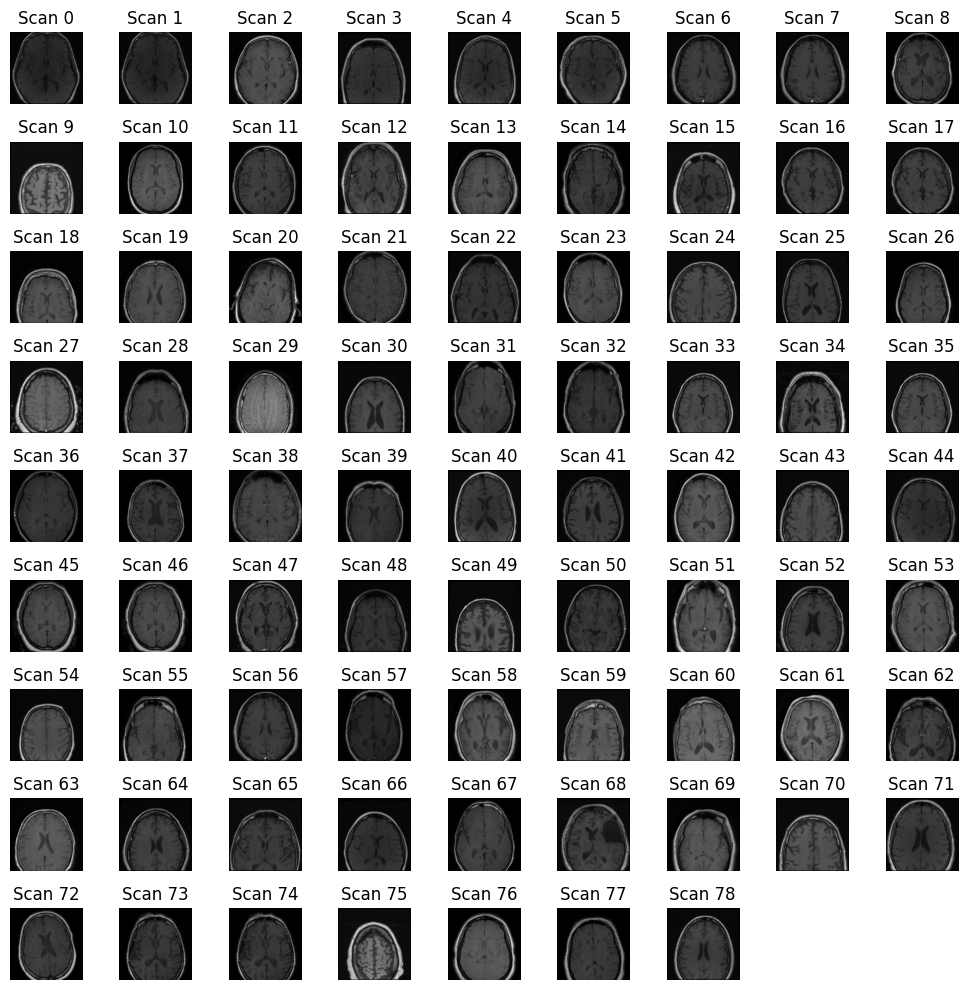

In [ ]:
# Calculate grid size
num_items = len(AX_T1_scan_list)
grid_size = int(np.ceil(np.sqrt(num_items)))  # Grid dimensions (rows and cols)

# Create subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Flatten axes for easier iteration
axes = axes.ravel()

# Iterate through the list and plot each last element
for i in range(num_items):
    ax = axes[i]
    ax.imshow(AX_T1_scan_list[i][-1], cmap='gray')  # Replace `cmap` as needed
    ax.set_title(f"Scan {i}")
    ax.axis('off')  # Hide axes

# Hide any unused subplot areas
for j in range(num_items, grid_size * grid_size):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
rev_indices = [51, 60, 50, 59]
for i in rev_indices:
    AX_T1_segmentation_list[i] = np.flip(AX_T1_segmentation_list[i], 0)
    AX_T1_scan_list[i] = np.flip(AX_T1_scan_list[i], 0)

In [ ]:
AX_T1_segmentation_list_stacked = np.concatenate(AX_T1_segmentation_list, axis=0)
AX_T1_segmentation_list_stacked = AX_T1_segmentation_list_stacked.astype(np.int8)

In [ ]:
import io

seg_file = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data', 'AX_T1_segmentations.npy'])
# Obtain numpy arrays from box drive
seg_byte_io = io.BytesIO(seg_file.get().content())
seg = np.load(seg_byte_io)
del seg_byte_io

In [ ]:
half = len(AX_T1_segmentation_list_stacked)
print(AX_T1_segmentation_list_stacked[:half].shape, AX_T1_segmentation_list_stacked_old[:half].shape)
print(np.sum(AX_T1_segmentation_list_stacked[:half]), np.sum(AX_T1_segmentation_list_stacked_old[:half]))

(1591, 512, 512) (1591, 512, 512)
470273 471474


6
7
8
9
10
11
12
22
23
24
25
26
27
28
37
38
39
40
41
42
43
44
58
59
60
61
75
76
77
91
92
93
94
95
96
110
111
112
113
114
130
131
132
133
134
135
152
153
154
155
182
183
184
185
210
211
212
213
214
231
251
252
253
254
255
256
269
270
271
272
282
283
284
285
300
301
302
303
304
318
319
320
321
322
323
324
325
326
338
339
340
341
342
343
344
345
346
358
359
373
374
375
376
377
378
398
399
400
401
402
419
420
421
422
423
424
436
437
438
439
440
458
459
460
461
462
463
478
479
480
481
482
483
504
505
506
507
508
509
527
528
529
552
553
554
555
574
575
576
577
578
590
591
592
593
594
595
615
616
617
634
635
636
648
649
650
651
652
653
665
666
667
668
669
670
685
686
687
688
706
707
708
709
710
724
726
727
728
729
730
742
743
744
745
761
762
763
764
765
775
776
777
778
794
795
796
797
798
817
818
819
820
838
839
840
841
858
859
860
861
862
863
890
891
892
908
909
910
911
912
928
929
930
931
932
933
947
948
949
950
951
968
969
970
971
972
973
990
991
992
993
994
1014
1015
1016
1017
1018
1019
1

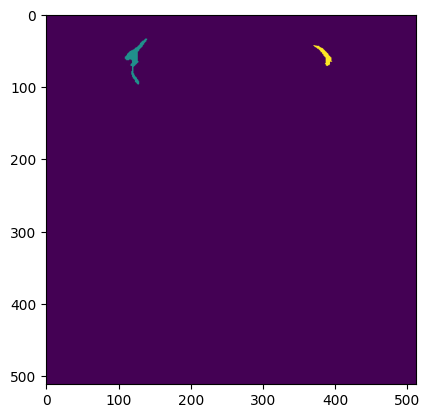

In [ ]:
for i, d in enumerate(AX_T1_segmentation_list_stacked):
    if (np.sum(d) != 0):
        print(i)
        # print(i, d)
plt.imshow(AX_T1_segmentation_list_stacked[8])

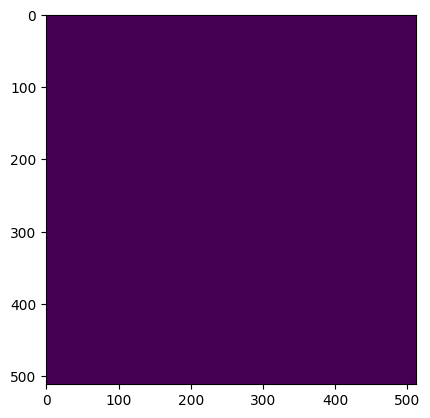

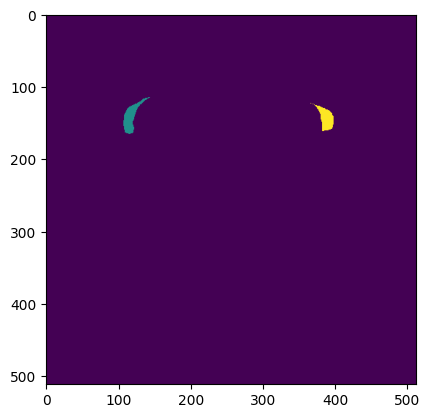

In [ ]:
i = 779
plt.imshow(AX_T1_segmentation_list_stacked[i])
plt.figure()
plt.imshow(AX_T1_segmentation_list_stacked_old[i])

In [ ]:
np.sum(seg/len(seg))

309.6368159203981

In [ ]:
np.sum(AX_T1_segmentation_list_stacked/len(AX_T1_segmentation_list_stacked))

295.58328095537576

In [ ]:
np.sum(seg[:30])

8714

In [ ]:
np.sum(AX_T1_segmentation_list_stacked[:30])

13190

In [ ]:
AX_T1_segmentation_list_stacked[:30]

In [ ]:
#Saving Files locally

AX_T1_scan_list_stacked = np.concatenate(AX_T1_scan_list, axis=0)
AX_T1_scan_list_stacked = AX_T1_scan_list_stacked.astype(np.int32)
np.save("AX_T1_scans", AX_T1_scan_list_stacked)

AX_T1_segmentation_list_stacked = np.concatenate(AX_T1_segmentation_list, axis=0)
AX_T1_segmentation_list_stacked = AX_T1_segmentation_list_stacked.astype(np.int8)
np.save("AX_T1_segmentations", AX_T1_segmentation_list_stacked)

AX_T1_segmentation_list_foreground_stacked = np.concatenate(AX_T1_segmentation_list_foreground, axis=0)
AX_T1_segmentation_list_foreground_stacked = AX_T1_segmentation_list_foreground_stacked.astype(np.int8)
np.save("AX_T1_segmentations_foreground", AX_T1_segmentation_list_foreground_stacked)

np.save("AX_T1_IDs", AX_T1_IDs)

In [ ]:
#Saving Files to box

def save_numpy_to_box(file_path):
    print(file_path)
    current_box_folder = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data'])
    box_file = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data', file_path])
    if (box_file != -1):
        box_file.delete()
    with open(file_path, 'rb') as file_stream:
        current_box_folder.upload_stream(file_stream, file_path)

save_numpy_to_box("AX_T1_scans.npy")
save_numpy_to_box("AX_T1_segmentations.npy")
save_numpy_to_box("AX_T1_segmentations_foreground.npy")
save_numpy_to_box("AX_T1_IDs.npy")

AX_T1_scans.npy
AX_T1_segmentations.npy
AX_T1_segmentations_foreground.npy
AX_T1_IDs.npy


In [ ]:
#Processing Files

POST_AX_T1_frame_sizes = get_frame_sizes(POST_AX_T1_FS_segmentations)
POST_AX_T1_FS_segmentation_list = extract_scans(POST_AX_T1_FS_segmentations, POST_AX_T1_frame_sizes)
POST_AX_T1_FS_segmentation_list = assign_correct_direction(POST_AX_T1_FS_segmentation_list)
POST_AX_T1_FS_segmentation_list_foreground = get_foreground_areas(POST_AX_T1_FS_segmentation_list)
POST_AX_T1_FS_IDs = get_IDs(POST_AX_T1_FS_segmentation_list, POST_AX_T1_FS_scan_folders_names)
POST_AX_T1_FS_scan_list = extract_scans(POST_AX_T1_FS_scans, POST_AX_T1_frame_sizes)

rev_indices = [65]
for i in rev_indices:
    POST_AX_T1_FS_segmentation_list[i] = np.flip(POST_AX_T1_FS_segmentation_list[i], 0)
    POST_AX_T1_FS_scan_list[i] = np.flip(POST_AX_T1_FS_scan_list[i], 0)

In [ ]:
#Saving Files locally

POST_AX_T1_FS_scan_list_stacked = np.concatenate(POST_AX_T1_FS_scan_list, axis=0)
POST_AX_T1_FS_scan_list_stacked = POST_AX_T1_FS_scan_list_stacked.astype(np.int32)
np.save("POST_AX_T1_FS_scans", POST_AX_T1_FS_scan_list_stacked)

POST_AX_T1_FS_segmentation_list_stacked = np.concatenate(POST_AX_T1_FS_segmentation_list, axis=0)
POST_AX_T1_FS_segmentation_list_stacked = POST_AX_T1_FS_segmentation_list_stacked.astype(np.int8)
np.save("POST_AX_T1_FS_segmentations", POST_AX_T1_FS_segmentation_list_stacked)

POST_AX_T1_FS_segmentation_list_foreground_stacked = np.concatenate(POST_AX_T1_FS_segmentation_list_foreground, axis=0)
POST_AX_T1_FS_segmentation_list_foreground_stacked = POST_AX_T1_FS_segmentation_list_foreground_stacked.astype(np.int8)
np.save("POST_AX_T1_FS_segmentations_foreground", POST_AX_T1_FS_segmentation_list_foreground_stacked)

np.save("POST_AX_T1_FS_IDs", POST_AX_T1_FS_IDs)

In [ ]:
#Processing Files

def save_numpy_to_box(file_path):
    print(file_path)
    current_box_folder = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data'])
    box_file = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data', file_path])
    if (box_file != -1):
        box_file.delete()
    with open(file_path, 'rb') as file_stream:
        current_box_folder.upload_stream(file_stream, file_path)

save_numpy_to_box("POST_AX_T1_FS_scans.npy")
save_numpy_to_box("POST_AX_T1_FS_segmentations.npy")
save_numpy_to_box("POST_AX_T1_FS_segmentations_foreground.npy")
save_numpy_to_box("POST_AX_T1_FS_IDs.npy")

{'server': 'nginx', 'date': 'Mon, 20 Jan 2025 17:30:46 GMT', 'content-type': 'application/json', 'Content-Length': '489', 'cache-control': 'no-cache, no-store', 'x-envoy-upstream-service-time': '395', 'strict-transport-security': 'max-age=31536000', 'via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'}
<No content or content unavailable for logging>

{'server': 'nginx', 'date': 'Mon, 20 Jan 2025 17:32:50 GMT', 'content-type': 'application/json', 'Content-Length': '501', 'cache-control': 'no-cache, no-store', 'x-envoy-upstream-service-time': '375', 'strict-transport-security': 'max-age=31536000', 'via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'}
<No content or content unavailable for logging>

{'server': 'nginx', 'date': 'Mon, 20 Jan 2025 17:33:55 GMT', 'content-type': 'application/json', 'Content-Length': '480', 'cache-control': 'no-cache, no-store', 'x-envoy-upstream-service-time': '496', 'strict-transport-security': 'max-age

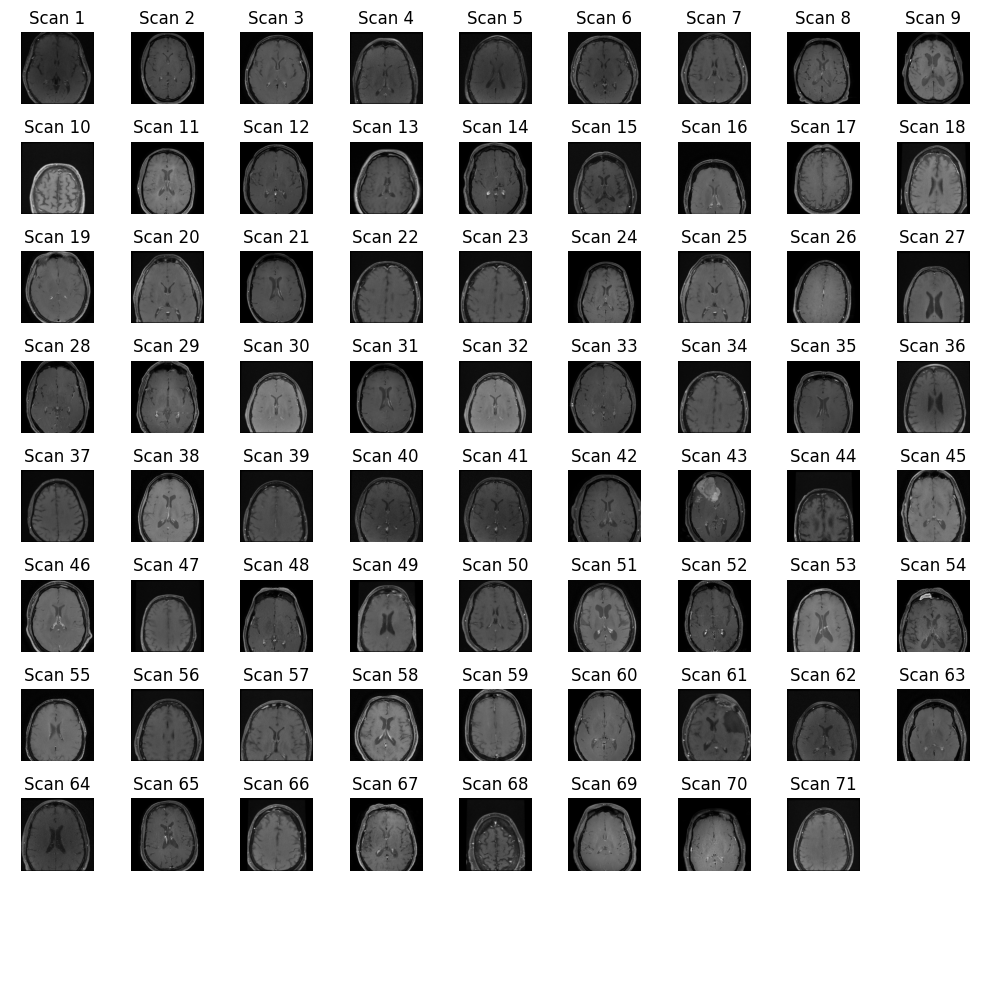

In [ ]:
# Calculate grid size
num_items = len(POST_AX_T1_FS_scan_list)
grid_size = int(np.ceil(np.sqrt(num_items)))  # Grid dimensions (rows and cols)

# Create subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Flatten axes for easier iteration
axes = axes.ravel()

# Iterate through the list and plot each last element
for i in range(num_items):
    ax = axes[i]
    ax.imshow(POST_AX_T1_FS_scan_list[i][-1], cmap='gray')  # Replace `cmap` as needed
    ax.set_title(f"Scan {i+1}")
    ax.axis('off')  # Hide axes

# Hide any unused subplot areas
for j in range(num_items, grid_size * grid_size):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
pip install pynrrd

In [ ]:
import numpy as np
import nrrd

# Example segmentation NumPy array (3D)
segmentation_1 = AX_T1_segmentation_list[0]  # Binary segmentation example
segmentation_2 = AX_T1_segmentation_list[0]

# Stack segmentations as a 4D array (2, H, W, D)
segmentation_stack = np.stack([segmentation_1, segmentation_2], axis=0)

# Define metadata with labels for each segmentation
header = {
    'type': 'uint8',
    'dimension': 4,  # Storing as a 4D array (segmentation layers)
    'sizes': segmentation_stack.shape,  # Shape: (2, 128, 128, 64)
    'space': 'left-posterior-superior',
    'encoding': 'gzip',
    'labels': ['Segmentation_1', 'Segmentation_2']  # Metadata to distinguish them
}

# Save the multi-segmentation NRRD file
nrrd.write("multi_segmentation.nrrd", segmentation_stack, header)

In [ ]:
seg_file_new = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', '90878290', 'Annotations', 'AX_T1', 'LG_Segmentations.seg.nrrd'])
seg_file_old = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', '90878290', 'Annotations', 'Old_AX_T1', 'LG_Segmentations.seg.nrrd'])

seg_new = loadNRRD(seg_file_new)
seg_old = loadNRRD(seg_file_old)

In [ ]:
print(seg_new.shape)
print(seg_old.shape)

(20, 512, 512)
(20, 512, 512)


In [ ]:
np.sum(seg_new - seg_old, axis = (1, 2))

array([   0,    0,    0,    0,    0,    0,  732,    0,    0,    0,    0,
        502, 1633, 1083,    0,    0,    0,    0,    0,    0], dtype=uint64)

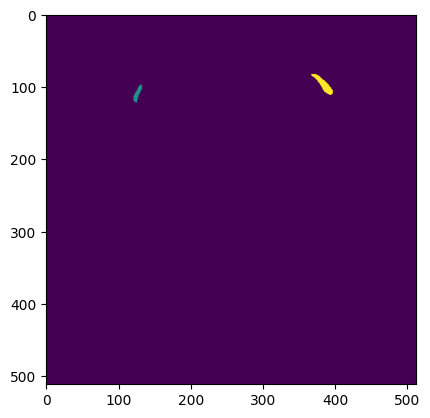

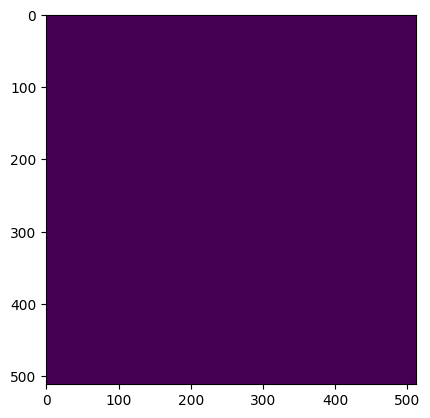

In [ ]:
plt.imshow(seg_new[6])
plt.figure()
plt.imshow(seg_old[6])

In [ ]:
parent_dir = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training'])
pattern = r'\d{8}'#choosing all files with 8 number digits

for item in parent_dir.get_items():
    print(item.name)
    if re.match(pattern, item.name):
        folder = navigTo(item, "Annotations")
        if (folder == -1):
            continue
        old_folder = navigTo(folder, "OLD")
        if (old_folder != -1):
            print(item.name)
            new_folder = folder.create_subfolder("Old_AX_T1")
            folder_with_AX_T1_files = navigTo(old_folder, "AX_T1")
            for file in folder_with_AX_T1_files.get_items():
                print("Moving", file.name)
                moved_file = file.move(new_folder)
            old_folder.delete(force=True)

        old_folder = navigTo(folder, "Old")
        if (old_folder != -1):
            print(item.name)
            new_folder = folder.create_subfolder("Old_AX_T1")
            folder_with_AX_T1_files = navigTo(old_folder, "AX_T1")
            for file in folder_with_AX_T1_files.get_items():
                print("Moving", file.name)
                moved_file = file.move(new_folder)
            old_folder.delete(force=True)